In [1]:
import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imp import reload
from scipy.linalg import subspace_angles
from sklearn.linear_model import LinearRegression as LR

import cca
from cca import ComplexityComponentsAnalysis as CCA
from cca import methods_comparison as mc
from cca import synth_data
from cca.analysis import linear_decode_r2

# Comparison with PCA

From an analysis perspective, the goal of PCA is to find the subspace that maximizes the projected variance of the data. If the dimensions with dynamics have low variance compared to the noise dimensions, PCA will not recover the dynamics.

Here, we show this on a dataset where the first two dimensions are GPs with different kernels and kernel parameters and variance=1. The second two dimensions are multivariate noise with variances 5 and 2 respectively.

In [ ]:
n_samples = 1000
GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=3., local_noise=.01)
X1 = synth_data.sample_gp(n_samples, 1, GP_ker)
GP_ker = synth_data.gen_gp_kernel('exp', spatial_scale=2., temporal_scale=5., local_noise=.01)
X2 = synth_data.sample_gp(n_samples, 1, GP_ker)
X3 = np.random.multivariate_normal([0., 0.], [[5., 0.], [0., 2]], size=n_samples)
X = np.concatenate([X1, X2, X3], axis=1)
proj = np.zeros((X.shape[1], 2))
proj[0, 0] = 1
proj[1, 1] = 1

In [ ]:
pca = PCA(n_components=2).fit(X)
print(pca.components_.T)
print(subspace_angles(proj, pca.components_.T))

In [ ]:
cca = CCA(d=1, T=5, n_init=5).fit(X)
print(cca.coef_)

cca = CCA(d=2, T=5, n_init=5).fit(X)
print(cca.coef_)
print(subspace_angles(proj, cca.coef_))

# Comparison to SFA
SFA is only sensitive to the autocorrelation at one time-lag wheras DCA is sensitive to all auto and crosscorrelations at up to 2T time-lags.

In [17]:
T = 50
noise = .01
taus = np.linspace(.9, 1., 100)
gauss_pi = np.zeros_like(taus)
exp_pi = np.zeros_like(taus)
gauss_ac1 = np.zeros_like(taus)
exp_ac1 = np.zeros_like(taus)

In [18]:
for ii, tau in enumerate(taus):
    gauss_k = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau)
    exp_k = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
    gauss_cov = synth_data.gen_gp_cov(gauss_k, T, 1)
    exp_cov = synth_data.gen_gp_cov(exp_k, T, 1)
    gauss_ac1[ii] = gauss_cov[0, 1]
    exp_ac1[ii] = exp_cov[0, 1]
    gauss_pi[ii] = synth_data.calc_pi_for_gp(gauss_k, T, 1)
    exp_pi[ii] = synth_data.calc_pi_for_gp(exp_k, T, 1)

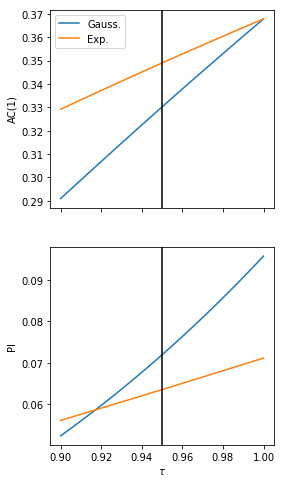

In [19]:
tau = .95
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 8))
ax1.plot(taus, gauss_ac1, label='Gauss.')
ax1.plot(taus, exp_ac1, label='Exp.')
ax1.set_ylabel('AC(1)')
ax1.axvline(tau, 0, 1, c='k')
ax1.legend(loc='best')

ax2.plot(taus, gauss_pi)
ax2.plot(taus, exp_pi)
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel('PI')
ax2.axvline(tau, 0, 1, c='k')

In [20]:
n_samples = 1000
GP1_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau)
GP2_ker = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
X1 = synth_data.sample_gp(n_samples, 1, GP1_ker, num_to_concat=10) * 2.
X2 = synth_data.sample_gp(n_samples, 1, GP2_ker, num_to_concat=10)
#X2 = np.random.randn(n_samples, 1)
X = np.concatenate([X1, X2], axis=1)

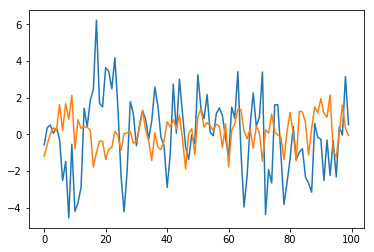

In [21]:
plt.plot(X1[:100])
plt.plot(X2[:100])

In [22]:
reload(mc)
sfa_model = mc.SlowFeatureAnalysis(1).fit(X)
print(sfa_model.coef_)

[[-0.08550661]
 [-0.9963376 ]]


In [23]:
cca_model = CCA(d=1, T=1, n_init=5).fit(X)
print(cca_model.coef_)

[[-0.08314083]
 [-0.99653781]]


In [24]:
cca_model = CCA(d=1, T=2, n_init=5).fit(X)
print(cca_model.coef_)

[[-0.9960485 ]
 [-0.08881093]]


# Comparison with GPFA

In [2]:
def gen_gp_concat_noise(n_samples, n_concat, noise_dims):
    GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=.5, temporal_scale=6., local_noise=.002)
    X1 = synth_data.sample_gp(n_samples, 3, GP_ker, num_to_concat=n_concat)
    mu = np.zeros(noise_dims)
    cov = np.diag(np.linspace(1, 4, noise_dims))
    Xn = np.random.multivariate_normal(mu, cov, size=n_samples * n_concat)
    X = np.concatenate([X1, Xn], axis=1)
    return X

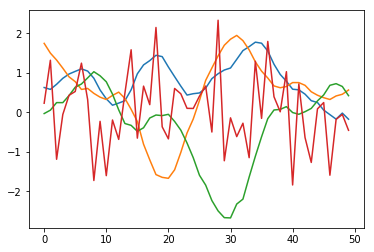

In [3]:
ns = 50
n_concat = 2
noise_dim = 27
X = gen_gp_concat_noise(ns, n_concat, noise_dim)
X = X.reshape(n_concat, ns, -1)
plt.plot(X[0][:, :4])

In [4]:
X.shape

(2, 50, 30)

In [ ]:
noise_dims = np.array([6, 12, 18, 24, 27])
ns = 50
n_concat =160
noise_dim = noise_dims.size
n_tol = 7
gp_tols = np.logspace(-5, -.1, n_tol)[::-1]
dca_tols = np.logspace(-6, -.1, n_tol)[::-1]
n_repeat = 3
r2 = np.zeros((3, noise_dim, n_tol, n_repeat))
times = np.zeros((3, noise_dim, n_tol, n_repeat))

for ii in range(n_tol):
    for jj in range(n_repeat):
        for kk, nd in enumerate(noise_dims):
            print(nd, gp_tols[ii], dca_tols[ii], jj)
            X = gen_gp_concat_noise(ns, n_concat, nd)
            X = X.reshape(n_concat, ns, -1)
            print(X.shape)
            Xtest = gen_gp_concat_noise(ns, n_concat, nd)
            Xtest = Xtest.reshape(n_concat, ns, -1)
            print('gpfa')
            # GPFA
            Xc = X.copy()
            start = time.time()
            gpfa = mc.GaussianProcessFactorAnalysis(n_factors=3, tol=gp_tols[ii])
            gpfa.fit(Xc)
            times[0, kk, ii, jj] = time.time() - start
            proj_train = np.concatenate(gpfa.transform(X))
            proj_test = np.concatenate(gpfa.transform(Xtest))
            r2[0, kk, ii, jj] = linear_decode_r2(proj_train, np.concatenate(X[..., :3]),
                                                 proj_test, np.concatenate(Xtest[..., :3]))
            # DCA
            print('dca')
            Xc = X.copy()
            start = time.time()
            cca_model = cca.ComplexityComponentsAnalysis(d=3, T=5, tol=dca_tols[ii])
            cca_model.estimate_cross_covariance(Xc)
            cca_model.fit_projection()
            times[1, kk, ii, jj] = time.time() - start
            proj_train = np.concatenate(cca_model.transform(X))
            proj_test = np.concatenate(cca_model.transform(Xtest))
            r2[1, kk, ii, jj] = linear_decode_r2(proj_train, np.concatenate(X[..., :3]),
                                                 proj_test, np.concatenate(Xtest[..., :3]))
            # DCA + GPFA
            print('both')
            Xc = X.copy()
            start = time.time()
            cca_model = cca.ComplexityComponentsAnalysis(d=2 * 3, T=5)
            cca_model.estimate_cross_covariance(Xc)
            cca_model.fit_projection()
            cca_proj = cca_model.transform(X)
            gpfa = mc.GaussianProcessFactorAnalysis(n_factors=3, tol=gp_tols[ii])
            gpfa.fit(cca_proj)
            times[2, kk, ii, jj] = time.time() - start
            proj_train = np.concatenate(gpfa.transform(cca_proj))
            proj_test = np.concatenate(gpfa.transform(cca_model.transform(Xtest)))
            r2[2, kk, ii, jj] = linear_decode_r2(proj_train, np.concatenate(X[..., :3]),
                                                 proj_test, np.concatenate(Xtest[..., :3]))

6 0.7943282347242815 0.7943282347242815 0
(160, 50, 9)
gpfa
dca
both
12 0.7943282347242815 0.7943282347242815 0
(160, 50, 15)
gpfa
dca
both
18 0.7943282347242815 0.7943282347242815 0
(160, 50, 21)
gpfa
dca
both
24 0.7943282347242815 0.7943282347242815 0
(160, 50, 27)
gpfa
dca
both
27 0.7943282347242815 0.7943282347242815 0
(160, 50, 30)
gpfa
dca
both
6 0.7943282347242815 0.7943282347242815 1
(160, 50, 9)
gpfa
dca
both
12 0.7943282347242815 0.7943282347242815 1
(160, 50, 15)
gpfa
dca
both
18 0.7943282347242815 0.7943282347242815 1
(160, 50, 21)
gpfa
dca
both
24 0.7943282347242815 0.7943282347242815 1
(160, 50, 27)
gpfa
dca
both
27 0.7943282347242815 0.7943282347242815 1
(160, 50, 30)
gpfa
dca
both
6 0.7943282347242815 0.7943282347242815 2
(160, 50, 9)
gpfa
dca
both
12 0.7943282347242815 0.7943282347242815 2
(160, 50, 15)
gpfa
dca
both
18 0.7943282347242815 0.7943282347242815 2
(160, 50, 21)
gpfa
dca
both
24 0.7943282347242815 0.7943282347242815 2
(160, 50, 27)
gpfa
dca
both
27 0.7943282

In [ ]:
for kk, nd in enumerate(noise_dims):
    plt.figure()
    plt.scatter(np.median(r2[0, kk, :, :], axis=-1), np.median(times[0, kk], axis=-1), label='GPFA')
    plt.scatter(np.median(r2[1, kk, :, :], axis=-1), np.median(times[1, kk], axis=-1), label='DCA')
    plt.scatter(np.median(r2[2, kk, :, :], axis=-1), np.median(times[2, kk], axis=-1), label='DCA+GPFA')
    plt.legend(loc='best')
    plt.yscale('log')
    plt.ylim(times.min() / 2, times.max() * 2)
    plt.xlabel(r'median $R^2$')
    plt.ylabel('median time')
    plt.title('nd: {}'.format(nd))

In [6]:
np.savez('dca_gpfa_results.npz', n_samples=n_samples, n_concats=n_concats, r2=r2, times=times,
         gp_tols=gp_tols, dca_tols=dca_tols, n_tol=n_tol, n_repeat=n_repeat)